In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from scipy.stats import randint,uniform
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,f1_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn import FunctionSampler
from sklearn.utils import resample

In [2]:
df= pd.read_csv('./CSC_classified_final_nway_red.csv')
df

,Unnamed: 0,CSC_CSC_ID,CSC_var_inter_prob_b,CSC_var_inter_sigma_b,CSC_var_inter_index_b,CSC_ks_intra_prob_b,CSC_kp_intra_prob_b,CSC_var_intra_index_b,CSC_var_intra_prob_b,CLASS_ID,CLASS_Class,CLASS_Source,dist_bayesfactor,dist_post,p_i,CSC_u/b,CSC_s/b,CSC_m/b,CSC_h/b
0,0,2CXO J171941.7-355418,NaN,NaN,-32768,0.110753,0.434036,0,0.479545,6019018,YSO,SIMBAD,10.624448,9.998668e-01,0.999985,NaN,NaN,0.034251,0.993514
1,1,2CXO J171919.8-355632,0.688725,2.157409e-07,5,0.940708,0.821869,2,0.749379,6018991,YSO,SIMBAD,9.840393,9.991906e-01,1.000000,0.0,0.000000,0.892446,0.000000
2,2,2CXO J171951.2-355325,0.563362,4.632072e-08,3,0.374751,0.604095,0,0.417616,6019047,YSO,SIMBAD,11.270465,9.999699e-01,1.000000,NaN,0.223416,0.437766,0.373852
3,3,2CXO J171956.0-355451,0.609957,5.897142e-08,4,0.379334,0.197464,0,0.369797,6019068,YSO,SIMBAD,11.659839,9.999877e-01,1.000000,NaN,0.094358,0.288578,0.693396
4,4,2CXO J171958.2-355333,0.702705,1.944157e-07,5,0.351655,0.315327,0,0.349900,6019089,YSO,SIMBAD,11.304786,9.999722e-01,1.000000,NaN,0.051214,0.077666,0.827113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47186,47186,2CXO J174626.1-284311,NaN,NaN,-32768,NaN,NaN,-32768,NaN,5944010,YSO,Michael A. Kuhn et al 2021 ApJS 254 33,9.396320,9.978077e-01,1.000000,NaN,NaN,NaN,NaN
47187,47187,2CXO J174549.4-284917,NaN,NaN,-32768,NaN,NaN,-32768,NaN,5433896,STAR,"(Skiff, 2009-2013)",7.274583,7.747192e-01,1.000000,NaN,NaN,NaN,NaN
47188,47188,2CXO J174539.0-290000,NaN,NaN,-32768,NaN,NaN,-32768,NaN,5813290,STAR,SIMBAD,-11.061596,1.585775e-18,1.000000,NaN,NaN,NaN,NaN
47189,47189,2CXO J174539.5-290059,NaN,NaN,-32768,NaN,NaN,1,NaN,5813379,STAR,SIMBAD,-101.120926,0.000000e+00,1.000000,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['Unnamed: 0', 'CSC_CSC_ID', 'CSC_var_inter_prob_b',
       'CSC_var_inter_sigma_b', 'CSC_var_inter_index_b', 'CSC_ks_intra_prob_b',
       'CSC_kp_intra_prob_b', 'CSC_var_intra_index_b', 'CSC_var_intra_prob_b',
       'CLASS_ID', 'CLASS_Class', 'CLASS_Source', 'dist_bayesfactor',
       'dist_post', 'p_i', 'CSC_u/b', 'CSC_s/b', 'CSC_m/b', 'CSC_h/b'],
      dtype='object')

In [4]:
ft=df.values[:,[2,3,4,5,6,7,8,15,16,17,18]]
ft

array([[nan, nan, -32768, ..., nan, 0.0342510233907318,
        0.9935137403120856],
       [0.68872468581017, 2.1574094492893e-07, 5, ..., 0.0,
        0.8924463542298487, 0.0],
       [0.5633617454848601, 4.6320716800618e-08, 3, ...,
        0.2234159989734346, 0.437766312091542, 0.373851719840085],
       ...,
       [nan, nan, -32768, ..., nan, nan, nan],
       [nan, nan, -32768, ..., nan, nan, nan],
       [0.970152595457372, 5.5751584932259e-06, 6, ...,
        0.2311717535287629, 0.0844134603451815, 0.5519425431520539]],
      dtype=object)

In [5]:
cl=df.values[:,10]

In [6]:
def normalise(ft):
    l,b= ft.shape
    for i in range(b):
        ft[:,i]= (ft[:,i]-np.nanmin(ft[:,i]))/(np.nanmax(ft[:,i])-np.nanmin(ft[:,i]))
    return ft

def high_neg_impute(ft):
    l,b= ft.shape
    for i in range(b):
        for j in range(l):
            if np.isnan(ft[j,i]):
                ft[j,i]= -1e+8
    return ft

In [7]:
ft=normalise(ft)
ft=high_neg_impute(ft)

/tmp/ipykernel_4354/43106251.py:4: RuntimeWarning: invalid value encountered in divide
  ft[:,i]= (ft[:,i]-np.nanmin(ft[:,i]))/(np.nanmax(ft[:,i])-np.nanmin(ft[:,i]))


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(cl)
y=le.transform(cl)

In [9]:
rf= RandomForestClassifier()

In [21]:
def remove_missing_data_effects(X,Y):
    X_neg= X
    X_neg[X_neg<0]= -1e+8
    return X_neg,Y

In [11]:
# def break_training_data(X,Y,major_class,n):
#     X_maj= X[Y==major_class]
#     Y_maj= Y[Y==major_class]
#     n_maj

In [12]:
# smote_pipeline = Pipeline([
#     ('smote', SMOTE(sampling_strategy='auto',k_neighbors=4)),
#     ('missing_data_effects_remove', FunctionSampler(func=remove_missing_data_effects, validate = False))
#     ('rf', rf)
# ])

# # Use StratifiedKFold for cross-validation
# cv = StratifiedKFold(n_splits=20, shuffle=True)

# # Train the LightGBM model using cross-validation with SMOTE
# y_pred = cross_val_predict(smote_pipeline, ft, y,cv=cv)

In [13]:
# from sklearn.metrics import confusion_matrix
# cf_matrix= confusion_matrix(y, y_pred)
# cf_matrix= cf_matrix.astype('float64')
# l=cf_matrix.shape[0]
# for i in range(l):
#     cf_matrix[i]=(cf_matrix[i]/np.sum(cf_matrix[i]))*100
# from sklearn.metrics import ConfusionMatrixDisplay
# ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
#                                display_labels=le.classes_).plot()

In [14]:
# from sklearn.metrics import classification_report
# print(classification_report(y,y_pred,target_names=le.classes_))

In [22]:
param_dist = {'rf__n_estimators': randint(10,200),
              'rf__max_depth': randint(6,20),
            'rf__min_samples_leaf': randint(1,60),
             'rf__max_features': uniform(0.1,1.0),
             'smote__k_neighbors': randint(3,10)}

# Create a random forest classifier
rf = RandomForestClassifier()

#create pipeline
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto')),
    ('missing_data_effects_remove', FunctionSampler(func=remove_missing_data_effects, validate = False)),
    ('rf', rf)
])

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

#create scorer
from sklearn.metrics import make_scorer
scorer = make_scorer(f1_score, average = 'macro')

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(pipeline, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=cv,scoring=scorer)

# Fit the random search object to the data
rand_search.fit(ft, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE()),
                                             ('missing_data_effects_remove',
                                              FunctionSampler(func=<function remove_missing_data_effects at 0x797ec48cdd00>,
                                                              validate=False)),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=5,
                   param_distributions={'rf__max_depth': <scipy.stats._distn_i...
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x797ec49f1bb0>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x797ec4a7c8f0>,
                                        'smote__k_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x797ec49f13d0>},
                   scoring=make_scorer(f1_score, response_method='predict', average=macro))

In [23]:
# Create a variable for the best model
best_pipeline = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'rf__max_depth': 17, 'rf__max_features': 0.10820916038683961, 'rf__min_samples_leaf': 24, 'rf__n_estimators': 47, 'smote__k_neighbors': 5}


In [24]:
best_pipeline

Pipeline(steps=[('smote', SMOTE()),
                ('missing_data_effects_remove',
                 FunctionSampler(func=<function remove_missing_data_effects at 0x797ec48cdd00>,
                                 validate=False)),
                ('rf',
                 RandomForestClassifier(max_depth=17,
                                        max_features=0.10820916038683961,
                                        min_samples_leaf=24,
                                        n_estimators=47))])

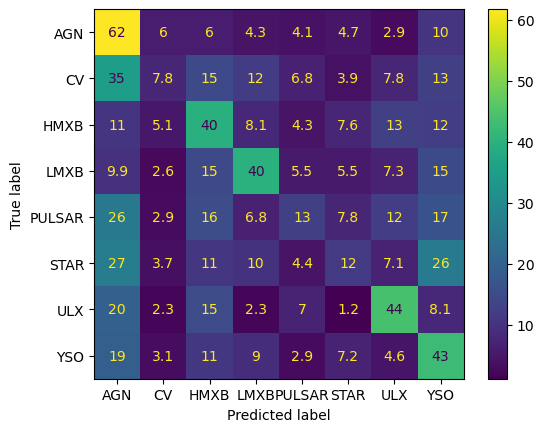

In [25]:
# smote_pipeline_best = Pipeline([
#     ('smote', SMOTE(sampling_strategy='auto',k_neighbors=4)),
#     ('rf', best_rf_smote)
# ])

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=20, shuffle=True)

# Train the LightGBM model using cross-validation with SMOTE
y_pred = cross_val_predict(best_pipeline, ft, y,cv=cv)
from sklearn.metrics import confusion_matrix
cf_matrix= confusion_matrix(y, y_pred)
cf_matrix= cf_matrix.astype('float64')
l=cf_matrix.shape[0]
for i in range(l):
    cf_matrix[i]=(cf_matrix[i]/np.sum(cf_matrix[i]))*100
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                               display_labels=le.classes_).plot()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y,y_pred,target_names=le.classes_))

              precision    recall  f1-score   support

         AGN       0.81      0.62      0.70     28869
          CV       0.00      0.08      0.01       103
        HMXB       0.04      0.40      0.07       396
        LMXB       0.05      0.40      0.09       384
      PULSAR       0.01      0.13      0.02       206
        STAR       0.29      0.12      0.17      7683
         ULX       0.02      0.44      0.04        86
         YSO       0.44      0.43      0.43      9464

    accuracy                           0.49     47191
   macro avg       0.21      0.33      0.19     47191
weighted avg       0.64      0.49      0.55     47191

